<a href="https://colab.research.google.com/github/vimuth97/Pump-It-Up/blob/main/pump_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [532]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [533]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler


# for dirname, _, filenames in os.walk('/content/drive'):
#     for filename in filenames:
#       print(os.path.join(dirname, filename))

train_values = pd.read_csv("/content/drive/MyDrive/Pump it up/training values.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/Pump it up/training labels.csv")
# test_data = pd.read_csv("/content/drive/MyDrive/Pump it up/test set.csv")

In [534]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [535]:
train_values.shape

(59400, 40)

Checking whether the dataset is balanced or not

In [536]:
print(train_labels['status_group'].value_counts())

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


In [537]:
train_values.isnull().sum().sort_values(ascending = False)

scheme_name              28166
scheme_management         3877
installer                 3655
funder                    3635
public_meeting            3334
permit                    3056
subvillage                 371
ward                         0
lga                          0
district_code                0
region_code                  0
region                       0
waterpoint_type_group        0
population                   0
num_private                  0
wpt_name                     0
latitude                     0
longitude                    0
gps_height                   0
date_recorded                0
amount_tsh                   0
basin                        0
recorded_by                  0
waterpoint_type              0
water_quality                0
source_class                 0
source_type                  0
source                       0
quantity_group               0
quantity                     0
quality_group                0
payment_type                 0
construc

In [538]:
amount = train_values['amount_tsh']
print(amount.max())
print(amount.min())

350000.0
0.0


Standardise `amount_tsh`, `population` because they have a large ranges and may contain outliers.
However tree based classifiers does not require standardisation 

In [539]:
train_values[['amount_tsh', 'population', 'num_private', 'gps_height']] = StandardScaler().fit_transform(train_values[['amount_tsh', 'population', 'num_private', 'gps_height']])
print(train_values[['amount_tsh', 'population', 'num_private', 'gps_height']])

       amount_tsh  population  num_private  gps_height
0        1.895665   -0.150399    -0.038749    1.041252
1       -0.105970    0.212290    -0.038749    1.054237
2       -0.097630    0.148660    -0.038749    0.025541
3       -0.105970   -0.258570    -0.038749   -0.584751
4       -0.105970   -0.381587    -0.038749   -0.964200
...           ...         ...          ...         ...
59395   -0.102634   -0.116463    -0.038749    0.781553
59396    1.461977   -0.262812    -0.038749    0.784439
59397   -0.105970   -0.381587    -0.038749   -0.964200
59398   -0.105970   -0.381587    -0.038749   -0.964200
59399   -0.105970   -0.063439    -0.038749   -0.688631

[59400 rows x 4 columns]


**Onehot encoding**

In [540]:
train_values_ohe = pd.get_dummies(train_values, prefix=["public_meeting", "permit"], columns=["public_meeting", "permit"], dummy_na=False)
# ohe_2 = pd.get_dummies(train_values.permit, prefix="permit")
train_values_ohe.shape

(59400, 42)

 Remove `region` feature because `region_code` provide coded version of same information

In [541]:
train_values_drop_region = train_values_ohe.drop(['region'], axis=1)

Pre-process `longitude` and `gps_height` by replacing 0 with mean value of each district.
In the dataset region>district>subvillage but subvillage has `na` values hence district is chosen to calculate the mean

In [542]:
print("minimum longitude", train_values_drop_region.longitude.min())
print("number of unavailable latitudes", len(train_values_drop_region[(train_values_drop_region['latitude']==-0.00000002)]))

minimum longitude 0.0
number of unavailable latitudes 1812


In [543]:
grouped = train_values_drop_region.groupby("district_code")

def replaceLongitude(group):
  mask = group==0
  group[mask] = group[~mask].mean()
  return group

def replaceLatitude(group):
  mask = group==-0.00000002
  group[mask] = group[~mask].mean()
  return group

mean_longitude = grouped.longitude.transform(replaceLongitude)
mean_latitude = grouped.latitude.transform(replaceLatitude)

train_values_drop_region.longitude = mean_longitude
train_values_drop_region.latitude = mean_latitude

In [544]:
#check for correctness of above process
print("minimum longitude:", train_values_drop_region.longitude.min()) 
print("number of unavailable latitudes:", len(train_values_drop_region[(train_values_drop_region['latitude']==-0.00000002)]))

minimum longitude: 29.6071219
number of unavailable latitudes: 0


In [545]:
print(train_values_drop_region.shape)

(59400, 41)


Preprocess `date_recorded` feature

In [546]:
train_values_drop_region['date_recorded'] =  pd.to_datetime(train_values['date_recorded'])
train_values_drop_region['num_days'] = (train_values_drop_region['date_recorded'] - pd.Timestamp.now())/np.timedelta64(1, 'D')
train_values_drop_region['num_days'] = StandardScaler().fit_transform(train_values_drop_region[['num_days']])
train_values_drop_date = train_values_drop_region.drop(['date_recorded'], axis=1)
print(train_values_drop_date.shape,'\n',train_values_drop_date['num_days'])

(59400, 41) 
 0       -1.141136
1        1.022152
2        0.995223
3        0.911444
4       -0.779092
           ...   
59395    1.195693
59396   -0.979562
59397   -1.057357
59398   -1.159088
59399   -1.114207
Name: num_days, Length: 59400, dtype: float64


In [547]:
print(train_values_drop_date.funder.value_counts())
print(train_values_drop_date.scheme_name.value_counts())

Government Of Tanzania      9084
Danida                      3114
Hesawa                      2202
Rwssp                       1374
World Bank                  1349
                            ... 
Eung-am Methodist Church       1
Said Salum Ally                1
Siza Mayengo                   1
Jwtz                           1
Rc Missi                       1
Name: funder, Length: 1897, dtype: int64
K                        682
None                     644
Borehole                 546
Chalinze wate            405
M                        400
                        ... 
Kasahunga pipe scheme      1
Mnazi moja                 1
Shallow Welll              1
BL Majengo                 1
REGWA                      1
Name: scheme_name, Length: 2696, dtype: int64


In [548]:
encoded_features = ['id','latitude','longitude','gps_height','date_recorded','amount_tsh','num_private',
                    'region_code','district_code','population','public_meeting','construction_year','permit',
                    'num_days','public_meeting_False','public_meeting_True','permit_False','permit_True','installer','wpt_name','subvillage']
limit = int(train_values_drop_date.shape[0]*0.03/100)

for column in train_values_drop_date.columns:
  if column not in encoded_features:
    feature_values=train_values_drop_date[column].value_counts()
    rare_features=feature_values[feature_values < limit]
    train_values_drop_date[column].replace(to_replace = list(rare_features.keys()), value = 'other', inplace = True)
    if ('other' in train_values_drop_date[column].value_counts().index):
      print('Changed', train_values_drop_date[column].value_counts()['other'], 'rows to other in column', column)
    train_values_drop_date[column], _ = train_values_drop_date[column].factorize(na_sentinel=-1, sort=True)

Changed 4308 rows to other in column funder
Changed 1 rows to other in column lga
Changed 7739 rows to other in column ward
Changed 1 rows to other in column scheme_management
Changed 10679 rows to other in column scheme_name
Changed 6432 rows to other in column extraction_type
Changed 6430 rows to other in column extraction_type_group
Changed 6430 rows to other in column extraction_type_class
Changed 844 rows to other in column management
Changed 943 rows to other in column management_group
Changed 1054 rows to other in column payment
Changed 1054 rows to other in column payment_type
Changed 212 rows to other in column source
Changed 278 rows to other in column source_type
Changed 6387 rows to other in column waterpoint_type
Changed 6387 rows to other in column waterpoint_type_group


In [549]:
train_values_drop_name = train_values_drop_date.drop(['wpt_name'], axis=1)    #drop 'wpt_name' (name of the waterpoint) due to highcardinality and less relevance to the prediction

In [ ]:
train_values_drop_date.head()

In [531]:
print(train_values_drop_date.wpt_name.value_counts())
print(train_values_drop_date.subvillage.value_counts())

none                   3563
Shuleni                1748
Zahanati                830
Msikitini               535
Kanisani                323
                       ... 
Kwa Daniel Mobe           1
Kwa Gasper Ngilisho       1
Ruocho B                  1
Kwa Hazumba               1
Kwa Mwikwa                1
Name: wpt_name, Length: 37400, dtype: int64
Madukani            508
Shuleni             506
Majengo             502
Kati                373
Mtakuja             262
                   ... 
Milala B              1
Nembora               1
Ikambaku              1
Nangunguru            1
Nyamadoke Center      1
Name: subvillage, Length: 19287, dtype: int64


In [ ]:
tot = train_data.shape[0]
train_data.dropna(inplace=True, subset=['Embarked'])    # drop rows with null values for Embarked attribute
print(tot - train_data.shape[0], "rows removed")

2 rows removed


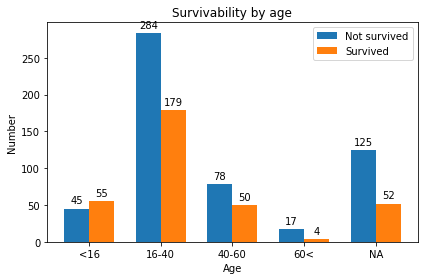

In [ ]:
# Visualise survivability w.r.t. Age
labels = ['<16', '16-40', '40-60', '60<', 'NA']
not_survived = [len(train_data[(train_data['Age']<=16) & (train_data['Survived']==0) & (train_data['Age']>0)]),
            len(train_data[(train_data['Age']>16) & (train_data['Survived']==0) & (train_data['Age']<=40)]),
            len(train_data[(train_data['Age']>40) & (train_data['Survived']==0) & (train_data['Age']<=60)]),
            len(train_data[(train_data['Age']>60) & (train_data['Survived']==0)]),
                len(train_data[np.isnan(train_data['Age']) & (train_data['Survived']==0)])]
survived = [len(train_data[(train_data['Age']<=16) & (train_data['Survived']==1) & (train_data['Age']>0)]),
            len(train_data[(train_data['Age']>16) & (train_data['Survived']==1) & (train_data['Age']<=40)]),
            len(train_data[(train_data['Age']>40) & (train_data['Survived']==1) & (train_data['Age']<=60)]),
            len(train_data[(train_data['Age']>60) & (train_data['Survived']==1)]),
            len(train_data[np.isnan(train_data['Age']) & (train_data['Survived']==1)])]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, not_survived, width, label='Not survived')
rects2 = ax.bar(x + width/2, survived, width, label='Survived')

ax.set_ylabel('Number')
ax.set_xlabel('Age')
ax.set_title('Survivability by age')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

 Imputing Age with mean value was less accurate compared to imputing with a constant.
 60 was selected observing the above graph NA and 60< has rate of survability

In [ ]:
# impute Age and Cabin

X['Cabin'].fillna('Missing', inplace=True) 
# X['Age'].fillna(round((X['Age'].mean()),2), inplace=True)    # impute Age with mean
X['Age'].fillna(60, inplace=True)    # imput Age with a constant

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
X_1 = pd.get_dummies(X.Sex)         # one hot encode column 'Sex'
X_2 = pd.get_dummies(X.Embarked, prefix="Embarked")    # one hot encode column 'Embarked'

In [ ]:
# reduce cardinality of Cabin
X_3 = pd.DataFrame()

X_3["CabinSClass"] = X.Cabin.str[0]
X_3["CabinSClass"].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:
X_dropped = X.drop(['Sex', 'Embarked', 'Cabin'], axis=1)
X_new = X_dropped.join([X_1, X_2, X_3])

In [ ]:
# Label encoding for CabinSClass
for colname in X_new.select_dtypes("object"):
    X_new[colname], _ = X_new[colname].factorize()

In [ ]:
# Utility functions from Tutorial
def make_mi_scores(X, y, features):
    X_mi = X.copy()
    mi_scores = mutual_info_classif(X_mi, y, discrete_features=features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Tried categorizing according to age but it caused less mutual information score and less test accuracy.

In [ ]:
# # Categorise by age limit 16
# X_new.loc[X_new.Age<=16, 'Age'] = 1
# X_new.loc[X_new.Age>16, 'Age'] = 0

female         0.149725
male           0.149725
Fare           0.135438
Pclass         0.057127
CabinSClass    0.053768
Age            0.042631
SibSp          0.023490
Parch          0.016653
Embarked_C     0.014079
Embarked_S     0.011335
Embarked_Q     0.000010
Name: MI Scores, dtype: float64


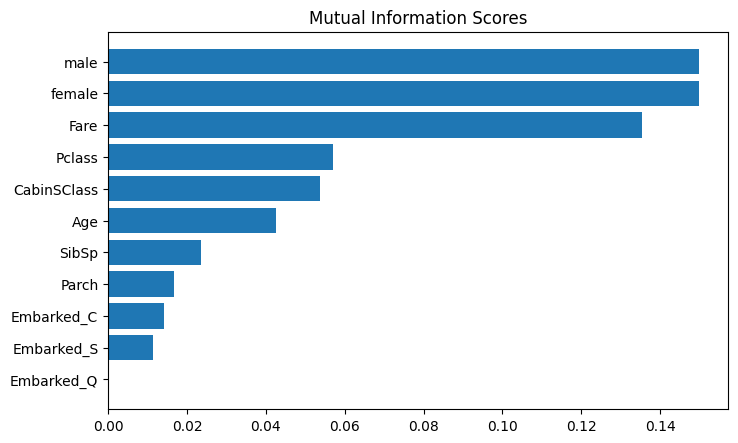

In [ ]:
# mutual inofrmation
features = [True, False, True, True, False,True, True, True, True, True, True ]
mi_scores = make_mi_scores(X_new, Y, features)
print(mi_scores.head(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))


In [ ]:
X_mi = X_new.drop(['Embarked_Q'], axis=1) # remove Embarked_Q feature due to low mutual information score

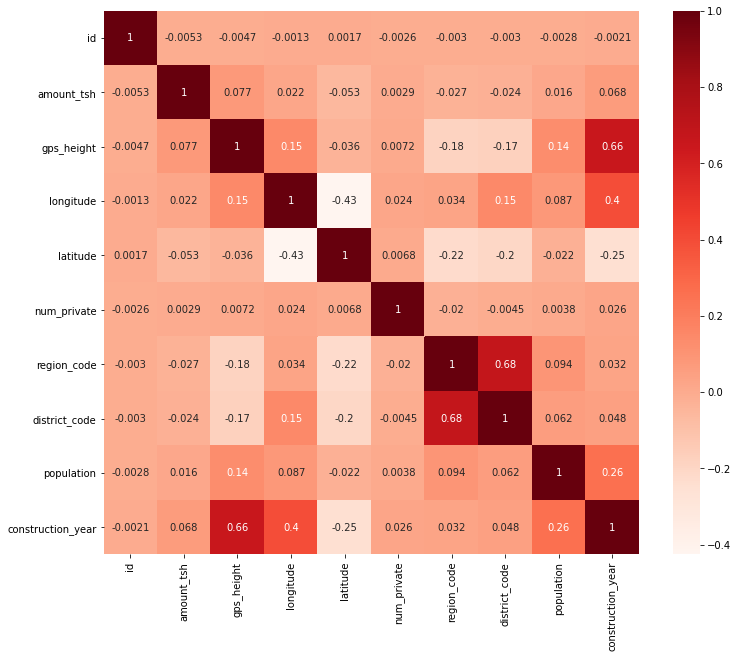

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = train_values.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
X_cor = X_mi.drop(['male'], axis=1) # remove 'male' feature due to high correlation

In [ ]:
test_data.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

In [ ]:
# preprocess test data
test_1 = pd.get_dummies(test_data.Sex)
test_2 = pd.get_dummies(test_data.Embarked, prefix="Embarked")
test_data['Cabin'].fillna('Missing', inplace=True)
test_data['Fare'].fillna(0, inplace=True)

#impute and categorise Age
test_data['Age'].fillna(60, inplace=True)
# test_data.loc[test_data.Age<=16, 'Age'] = 1
# test_data.loc[test_data.Age>16, 'Age'] = 0

temp = pd.DataFrame()
temp["CabinSClass"] = test_data.Cabin.str[0]

cabin_map = ['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']
test_3 = temp["CabinSClass"].replace(to_replace=cabin_map, value=[0, 1, 2, 3,4, 5, 6, 7, 8])

test_new = test_data.join([test_1, test_2, test_3])
test_dropped = test_new.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'male', 'Embarked_Q', 'Embarked'], axis=1)

In [ ]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X_cor, Y, test_size=0.2, random_state=0)

In [ ]:
# GridSearch for random forest classifier
param_grid = {
    'bootstrap': [True],
    'criterion': ['entropy'],
    'max_depth': [10, 20, 50],
    'max_features': [8, 9],
    'min_samples_leaf': [2,3],
    'min_samples_split': [12, 14],
    'n_estimators': [32, 48],
}
num_folds = 10
# Create a base model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = num_folds, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
# grid_search.fit(X_cor, Y)  # for submission
grid_search.best_params_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   20.2s finished


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 14,
 'n_estimators': 48}

In [ ]:
model = grid_search.best_estimator_

In [ ]:
# cross validation
scoring = ['f1']
scores = cross_validate(model, X_train, y_train,scoring=scoring, cv=num_folds, return_train_score=True)
print("%0.4f train F1 score with a standard deviation of %0.4f" % (scores['train_f1'].mean(), scores['train_f1'].std()))
print("%0.4f test F1 score with a standard deviation of %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))

0.8652 train F1 score with a standard deviation of 0.0086
0.7620 test F1 score with a standard deviation of 0.0710


In [ ]:
y_pred = model.predict(X_test)

# evaluation
print(confusion_matrix(y_test,y_pred).ravel())
print(classification_report(y_test,y_pred))
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 Score :', f1_score(y_test, y_pred))

[91 14 26 47]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       105
           1       0.77      0.64      0.70        73

    accuracy                           0.78       178
   macro avg       0.77      0.76      0.76       178
weighted avg       0.77      0.78      0.77       178

Accuracy : 0.7752808988764045
F1 Score : 0.7014925373134328


In [ ]:
# save predictions for test set
y_pred = model.predict(test_dropped)
results = pd.DataFrame()
results["PassengerId"] = test_data.PassengerId
results["Survived"] = y_pred
results.to_csv('output37.csv', index=False)